# 📷 Cifar-10 Image Classification

El conjunto de datos `CIFAR-10` consta de `60000` imágenes en color `32x32` en `10` clases, con `6000` imágenes por clase. Hay "50000" imágenes de entrenamiento y "10000" imágenes de prueba.

# 🔬 Definición del problema:

Dada una imagen, ¿podemos predecir la clase correcta de esta imagen?

Las imágenes son muy pequeñas (`32x32`) y al visualizarlas notarás lo difícil que es distinguirlas incluso para un humano.

En este cuaderno vamos a construir un modelo CNN que puede clasificar imágenes de varios objetos. Tenemos clase `10` de imágenes:
1. Avión
2. automóvil
3. pájaro
4. gato
5. ciervo
6. perro
7. rana
8. caballo
9. barco
10. camión

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# 📥 Load the data

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# 🖼 Data Visualization

/var/folders/v0/_dw0wx1s0kj764555vtjs38h0000gn/T/ipykernel_90312/260140420.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


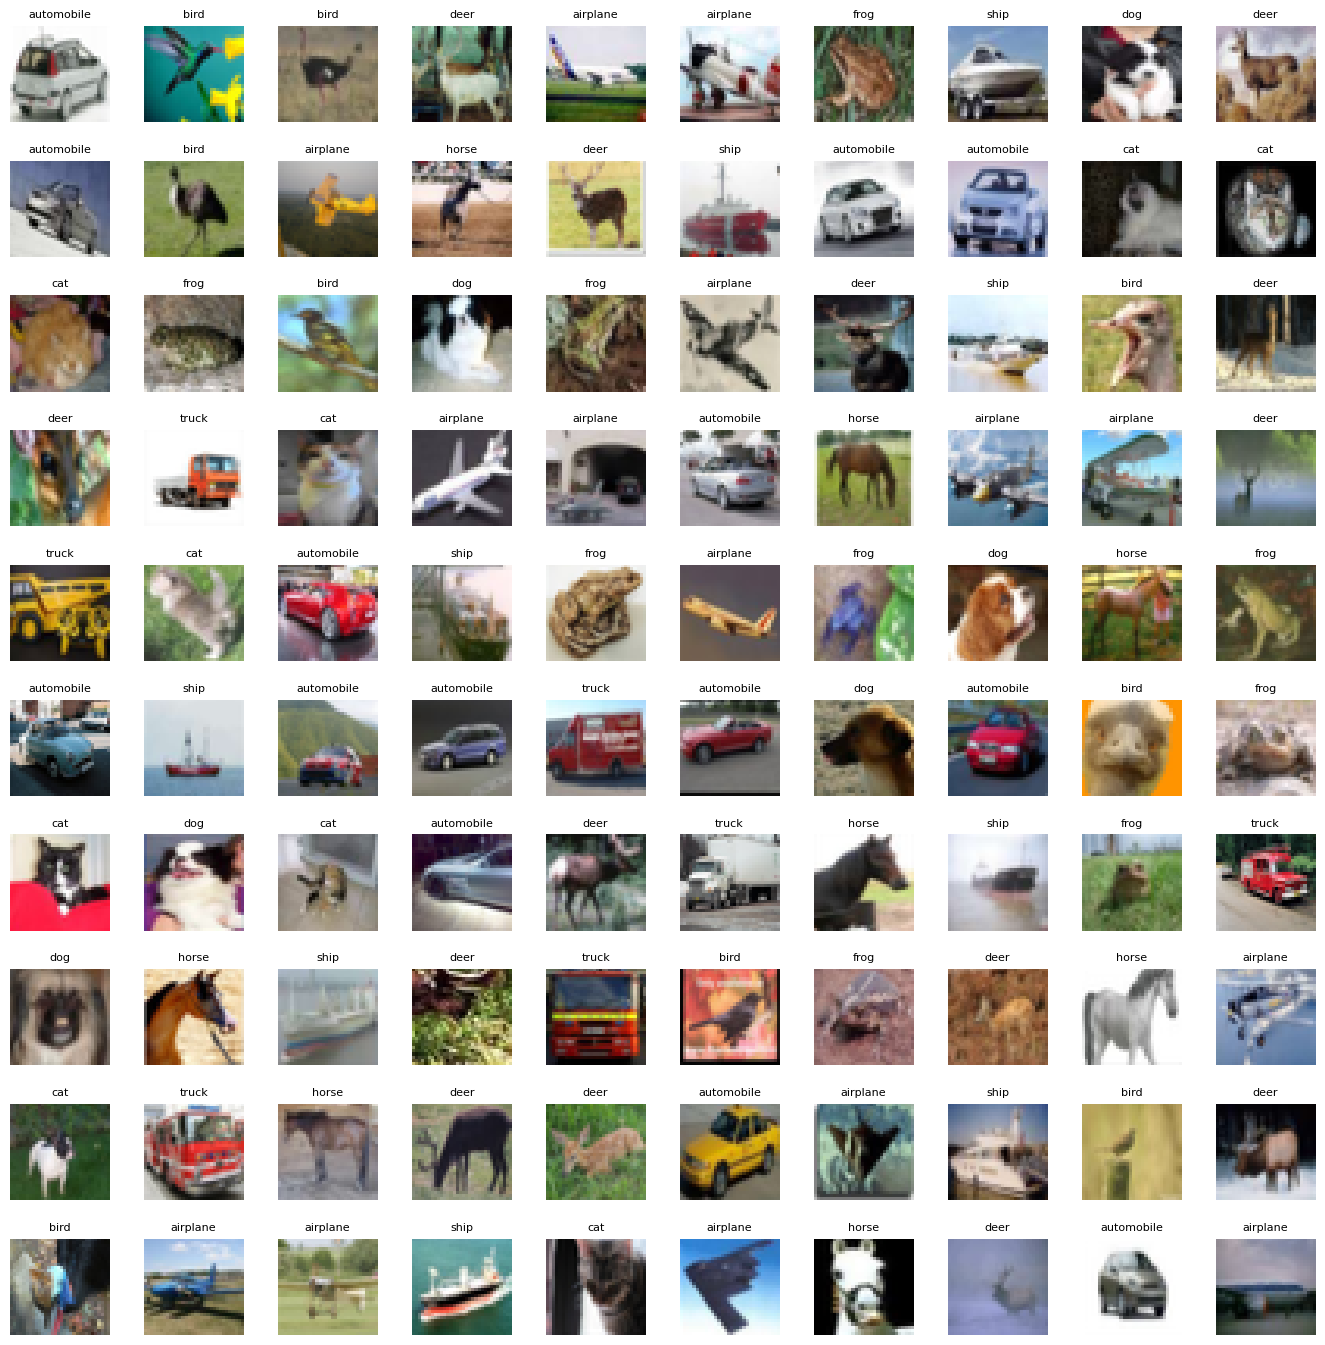

In [4]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

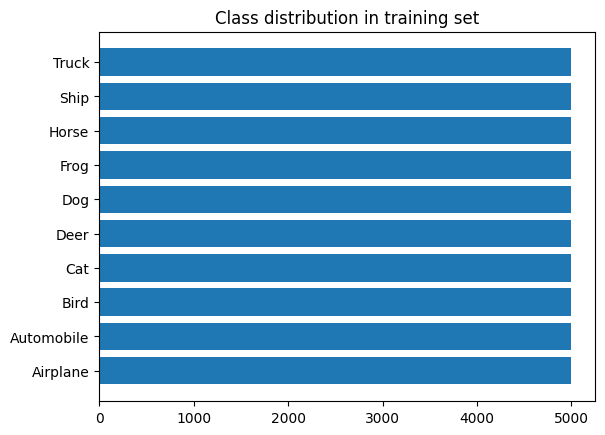

In [5]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

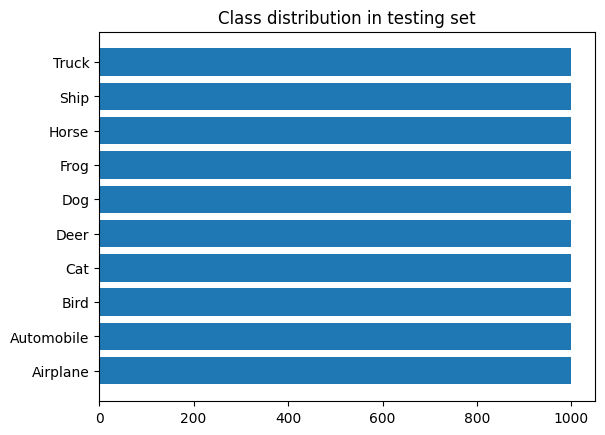

In [6]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

The class are equally distributed

# 🔄 Data Preprocessing

In [7]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [8]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# 🤖 Model Building

In [9]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,29

 Total params: 552,362 (2.11 MB)

 Trainable params: 551,466 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

## Early Stopping

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

## Data Augmentations

In [12]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:06:07 3s/step - accuracy: 0.0000e+00 - loss: 4.7935 - precision: 0.0000e+00 - recall: 0.0000e+00

/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 150s 94ms/step - accuracy: 0.3407 - loss: 1.8700 - precision: 0.5111 - recall: 0.1292 - val_accuracy: 0.5494 - val_loss: 1.2555 - val_precision: 0.6895 - val_recall: 0.4170
Epoch 2/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:44 144ms/step - accuracy: 0.5312 - loss: 1.5168 - precision: 0.7000 - recall: 0.2188

2024-05-18 09:42:39.269580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/santiagomunera/miniconda3/envs/ml/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5312 - loss: 1.5168 - precision: 0.7000 - recall: 0.2188 - val_accuracy: 0.5442 - val_loss: 1.2600 - val_precision: 0.6785 - val_recall: 0.4119
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.5502 - loss: 1.2614 - precision: 0.7142 - recall: 0.3789 - val_accuracy: 0.6674 - val_loss: 0.9666 - val_precision: 0.7801 - val_recall: 0.5510
Epoch 4/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:56 113ms/step - accuracy: 0.5000 - loss: 1.1429 - precision: 0.7647 - recall: 0.4062

2024-05-18 09:45:16.008167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5000 - loss: 1.1429 - precision: 0.7647 - recall: 0.4062 - val_accuracy: 0.6625 - val_loss: 0.9881 - val_precision: 0.7718 - val_recall: 0.5462
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 148s 95ms/step - accuracy: 0.6291 - loss: 1.0684 - precision: 0.7625 - recall: 0.4932 - val_accuracy: 0.6700 - val_loss: 0.9804 - val_precision: 0.7828 - val_recall: 0.5736
Epoch 6/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:39 102ms/step - accuracy: 0.6250 - loss: 0.9398 - precision: 0.7273 - recall: 0.5000

2024-05-18 09:47:50.691701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6250 - loss: 0.9398 - precision: 0.7273 - recall: 0.5000 - val_accuracy: 0.6837 - val_loss: 0.9335 - val_precision: 0.7918 - val_recall: 0.5861
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - accuracy: 0.6742 - loss: 0.9413 - precision: 0.7924 - recall: 0.5594 - val_accuracy: 0.6992 - val_loss: 0.8900 - val_precision: 0.7928 - val_recall: 0.6125
Epoch 8/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:32 98ms/step - accuracy: 0.7812 - loss: 0.6480 - precision: 0.8000 - recall: 0.6250

2024-05-18 09:50:24.553154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7812 - loss: 0.6480 - precision: 0.8000 - recall: 0.6250 - val_accuracy: 0.6993 - val_loss: 0.8843 - val_precision: 0.7926 - val_recall: 0.6142
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.7080 - loss: 0.8615 - precision: 0.8088 - recall: 0.6076 - val_accuracy: 0.7472 - val_loss: 0.7318 - val_precision: 0.8255 - val_recall: 0.6732
Epoch 10/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:21 90ms/step - accuracy: 0.6250 - loss: 1.0236 - precision: 0.7917 - recall: 0.5938

2024-05-18 09:52:50.376602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6250 - loss: 1.0236 - precision: 0.7917 - recall: 0.5938 - val_accuracy: 0.7503 - val_loss: 0.7242 - val_precision: 0.8274 - val_recall: 0.6761
Epoch 11/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 137s 88ms/step - accuracy: 0.7271 - loss: 0.7974 - precision: 0.8223 - recall: 0.6338 - val_accuracy: 0.7563 - val_loss: 0.7084 - val_precision: 0.8257 - val_recall: 0.6891
Epoch 12/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:19 89ms/step - accuracy: 0.6875 - loss: 0.7412 - precision: 0.7600 - recall: 0.5938

2024-05-18 09:55:13.675961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6875 - loss: 0.7412 - precision: 0.7600 - recall: 0.5938 - val_accuracy: 0.7552 - val_loss: 0.7093 - val_precision: 0.8262 - val_recall: 0.6879
Epoch 13/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - accuracy: 0.7375 - loss: 0.7638 - precision: 0.8278 - recall: 0.6521 - val_accuracy: 0.7773 - val_loss: 0.6640 - val_precision: 0.8434 - val_recall: 0.7183
Epoch 14/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:11 84ms/step - accuracy: 0.6875 - loss: 0.9239 - precision: 0.7600 - recall: 0.5938

2024-05-18 09:57:34.267768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6875 - loss: 0.9239 - precision: 0.7600 - recall: 0.5938 - val_accuracy: 0.7770 - val_loss: 0.6640 - val_precision: 0.8442 - val_recall: 0.7176
Epoch 15/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 135s 87ms/step - accuracy: 0.7554 - loss: 0.7155 - precision: 0.8372 - recall: 0.6798 - val_accuracy: 0.7822 - val_loss: 0.6651 - val_precision: 0.8411 - val_recall: 0.7298
Epoch 16/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:06 81ms/step - accuracy: 0.8125 - loss: 0.5722 - precision: 0.8462 - recall: 0.6875

2024-05-18 09:59:55.810221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8125 - loss: 0.5722 - precision: 0.8462 - recall: 0.6875 - val_accuracy: 0.7872 - val_loss: 0.6524 - val_precision: 0.8445 - val_recall: 0.7331
Epoch 17/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.7653 - loss: 0.6869 - precision: 0.8459 - recall: 0.6934 - val_accuracy: 0.7870 - val_loss: 0.6295 - val_precision: 0.8602 - val_recall: 0.7243
Epoch 18/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:12 85ms/step - accuracy: 0.8438 - loss: 0.5000 - precision: 0.8667 - recall: 0.8125

2024-05-18 10:02:14.873705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8438 - loss: 0.5000 - precision: 0.8667 - recall: 0.8125 - val_accuracy: 0.7831 - val_loss: 0.6383 - val_precision: 0.8579 - val_recall: 0.7218
Epoch 19/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 130s 84ms/step - accuracy: 0.7736 - loss: 0.6685 - precision: 0.8468 - recall: 0.7031 - val_accuracy: 0.8113 - val_loss: 0.5683 - val_precision: 0.8699 - val_recall: 0.7591
Epoch 20/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:16 87ms/step - accuracy: 0.8750 - loss: 0.3277 - precision: 0.9000 - recall: 0.8438

2024-05-18 10:04:31.951229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8750 - loss: 0.3277 - precision: 0.9000 - recall: 0.8438 - val_accuracy: 0.8108 - val_loss: 0.5685 - val_precision: 0.8691 - val_recall: 0.7570
Epoch 21/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.7820 - loss: 0.6402 - precision: 0.8562 - recall: 0.7167 - val_accuracy: 0.7980 - val_loss: 0.5978 - val_precision: 0.8557 - val_recall: 0.7435
Epoch 22/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:08 83ms/step - accuracy: 0.8438 - loss: 0.7599 - precision: 0.8667 - recall: 0.8125

2024-05-18 10:06:57.014911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8438 - loss: 0.7599 - precision: 0.8667 - recall: 0.8125 - val_accuracy: 0.8001 - val_loss: 0.5960 - val_precision: 0.8553 - val_recall: 0.7447
Epoch 23/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.7906 - loss: 0.6133 - precision: 0.8579 - recall: 0.7271 - val_accuracy: 0.8007 - val_loss: 0.6272 - val_precision: 0.8550 - val_recall: 0.7589
Epoch 24/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:58 76ms/step - accuracy: 0.7188 - loss: 0.7544 - precision: 0.7692 - recall: 0.6250

2024-05-18 10:09:08.530680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7188 - loss: 0.7544 - precision: 0.7692 - recall: 0.6250 - val_accuracy: 0.7992 - val_loss: 0.6273 - val_precision: 0.8544 - val_recall: 0.7578
Epoch 25/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 0.7965 - loss: 0.5940 - precision: 0.8628 - recall: 0.7377 - val_accuracy: 0.8024 - val_loss: 0.5925 - val_precision: 0.8528 - val_recall: 0.7579
Epoch 26/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:52 72ms/step - accuracy: 0.7812 - loss: 0.5447 - precision: 0.8846 - recall: 0.7188

2024-05-18 10:11:17.844358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7812 - loss: 0.5447 - precision: 0.8846 - recall: 0.7188 - val_accuracy: 0.8028 - val_loss: 0.5881 - val_precision: 0.8543 - val_recall: 0.7576
Epoch 27/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 78ms/step - accuracy: 0.8075 - loss: 0.5668 - precision: 0.8697 - recall: 0.7514 - val_accuracy: 0.7924 - val_loss: 0.6417 - val_precision: 0.8422 - val_recall: 0.7556
Epoch 28/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 3:15 125ms/step - accuracy: 0.8438 - loss: 0.4972 - precision: 0.8889 - recall: 0.7500

2024-05-18 10:13:25.256893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8438 - loss: 0.4972 - precision: 0.8889 - recall: 0.7500 - val_accuracy: 0.7920 - val_loss: 0.6424 - val_precision: 0.8439 - val_recall: 0.7537
Epoch 29/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 123s 78ms/step - accuracy: 0.8024 - loss: 0.5792 - precision: 0.8666 - recall: 0.7460 - val_accuracy: 0.8172 - val_loss: 0.5358 - val_precision: 0.8660 - val_recall: 0.7826
Epoch 30/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:03 79ms/step - accuracy: 0.8750 - loss: 0.4250 - precision: 0.8750 - recall: 0.8750

2024-05-18 10:15:34.119286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8750 - loss: 0.4250 - precision: 0.8750 - recall: 0.8750 - val_accuracy: 0.8187 - val_loss: 0.5329 - val_precision: 0.8660 - val_recall: 0.7841
Epoch 31/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.8147 - loss: 0.5433 - precision: 0.8727 - recall: 0.7618 - val_accuracy: 0.8195 - val_loss: 0.5513 - val_precision: 0.8661 - val_recall: 0.7827
Epoch 32/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:51 71ms/step - accuracy: 0.8438 - loss: 0.4032 - precision: 0.8966 - recall: 0.8125

2024-05-18 10:17:42.105022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8438 - loss: 0.4032 - precision: 0.8966 - recall: 0.8125 - val_accuracy: 0.8197 - val_loss: 0.5495 - val_precision: 0.8671 - val_recall: 0.7832
Epoch 33/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - accuracy: 0.8183 - loss: 0.5307 - precision: 0.8758 - recall: 0.7661 - val_accuracy: 0.8290 - val_loss: 0.5120 - val_precision: 0.8761 - val_recall: 0.7876
Epoch 34/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:49 70ms/step - accuracy: 0.8438 - loss: 0.5586 - precision: 0.8966 - recall: 0.8125

2024-05-18 10:19:47.243762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8438 - loss: 0.5586 - precision: 0.8966 - recall: 0.8125 - val_accuracy: 0.8254 - val_loss: 0.5172 - val_precision: 0.8736 - val_recall: 0.7860
Epoch 35/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.8190 - loss: 0.5355 - precision: 0.8751 - recall: 0.7661 - val_accuracy: 0.8216 - val_loss: 0.5447 - val_precision: 0.8666 - val_recall: 0.7871
Epoch 36/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:56 75ms/step - accuracy: 0.8125 - loss: 0.4243 - precision: 0.8966 - recall: 0.8125

2024-05-18 10:21:53.320591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8125 - loss: 0.4243 - precision: 0.8966 - recall: 0.8125 - val_accuracy: 0.8212 - val_loss: 0.5460 - val_precision: 0.8667 - val_recall: 0.7865
Epoch 37/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 123s 78ms/step - accuracy: 0.8251 - loss: 0.5141 - precision: 0.8796 - recall: 0.7743 - val_accuracy: 0.8408 - val_loss: 0.4720 - val_precision: 0.8775 - val_recall: 0.8096
Epoch 38/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:03 79ms/step - accuracy: 0.8125 - loss: 0.5205 - precision: 0.9286 - recall: 0.8125

2024-05-18 10:24:02.282704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8125 - loss: 0.5205 - precision: 0.9286 - recall: 0.8125 - val_accuracy: 0.8419 - val_loss: 0.4691 - val_precision: 0.8780 - val_recall: 0.8105
Epoch 39/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step - accuracy: 0.8310 - loss: 0.4976 - precision: 0.8834 - recall: 0.7833 - val_accuracy: 0.8387 - val_loss: 0.4738 - val_precision: 0.8808 - val_recall: 0.8038
Epoch 40/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:52 72ms/step - accuracy: 0.9062 - loss: 0.2868 - precision: 0.9333 - recall: 0.8750

2024-05-18 10:26:08.703886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9062 - loss: 0.2868 - precision: 0.9333 - recall: 0.8750 - val_accuracy: 0.8386 - val_loss: 0.4725 - val_precision: 0.8818 - val_recall: 0.8048
Epoch 41/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step - accuracy: 0.8311 - loss: 0.4883 - precision: 0.8839 - recall: 0.7868 - val_accuracy: 0.8510 - val_loss: 0.4425 - val_precision: 0.8946 - val_recall: 0.8142
Epoch 42/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:03 79ms/step - accuracy: 0.8125 - loss: 0.5866 - precision: 0.8571 - recall: 0.7500

2024-05-18 10:28:15.301970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8125 - loss: 0.5866 - precision: 0.8571 - recall: 0.7500 - val_accuracy: 0.8501 - val_loss: 0.4430 - val_precision: 0.8948 - val_recall: 0.8139
Epoch 43/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.8312 - loss: 0.4925 - precision: 0.8827 - recall: 0.7854 - val_accuracy: 0.8429 - val_loss: 0.4700 - val_precision: 0.8825 - val_recall: 0.8121
Epoch 44/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:50 71ms/step - accuracy: 0.7500 - loss: 0.7763 - precision: 0.8000 - recall: 0.7500

2024-05-18 10:30:22.774620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7500 - loss: 0.7763 - precision: 0.8000 - recall: 0.7500 - val_accuracy: 0.8447 - val_loss: 0.4687 - val_precision: 0.8846 - val_recall: 0.8140
Epoch 45/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 78ms/step - accuracy: 0.8354 - loss: 0.4828 - precision: 0.8845 - recall: 0.7898 - val_accuracy: 0.8469 - val_loss: 0.4552 - val_precision: 0.8912 - val_recall: 0.8097
Epoch 46/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:16 87ms/step - accuracy: 0.9062 - loss: 0.4938 - precision: 0.9310 - recall: 0.8438

2024-05-18 10:32:30.087128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9062 - loss: 0.4938 - precision: 0.9310 - recall: 0.8438 - val_accuracy: 0.8459 - val_loss: 0.4584 - val_precision: 0.8899 - val_recall: 0.8087
Epoch 47/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 78ms/step - accuracy: 0.8441 - loss: 0.4636 - precision: 0.8919 - recall: 0.8022 - val_accuracy: 0.8465 - val_loss: 0.4619 - val_precision: 0.8838 - val_recall: 0.8151
Epoch 48/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:56 74ms/step - accuracy: 0.8438 - loss: 0.5560 - precision: 0.8800 - recall: 0.6875

2024-05-18 10:34:37.467444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8438 - loss: 0.5560 - precision: 0.8800 - recall: 0.6875 - val_accuracy: 0.8451 - val_loss: 0.4651 - val_precision: 0.8822 - val_recall: 0.8139
Epoch 49/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.8433 - loss: 0.4590 - precision: 0.8909 - recall: 0.8019 - val_accuracy: 0.8425 - val_loss: 0.4714 - val_precision: 0.8808 - val_recall: 0.8103
Epoch 50/50
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 2:12 85ms/step - accuracy: 0.8750 - loss: 0.3004 - precision: 0.8710 - recall: 0.8438

2024-05-18 10:36:46.065904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8750 - loss: 0.3004 - precision: 0.8710 - recall: 0.8438 - val_accuracy: 0.8448 - val_loss: 0.4653 - val_precision: 0.8821 - val_recall: 0.8123


# 📊 Model Evaluation

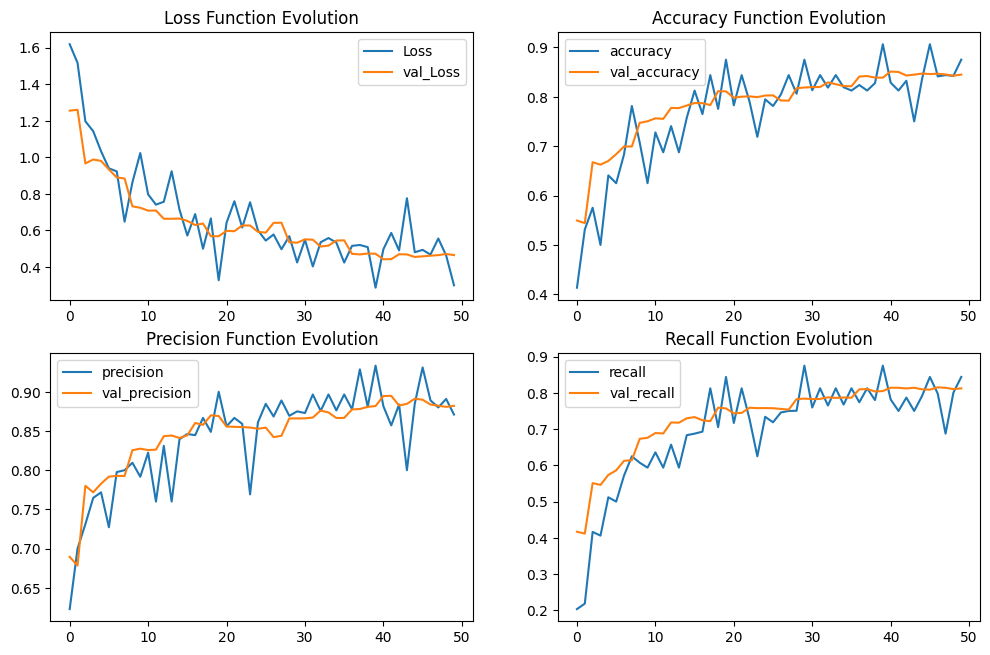

In [13]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8449 - loss: 0.4686 - precision: 0.8814 - recall: 0.8152
Test Accuracy : 84.48%
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


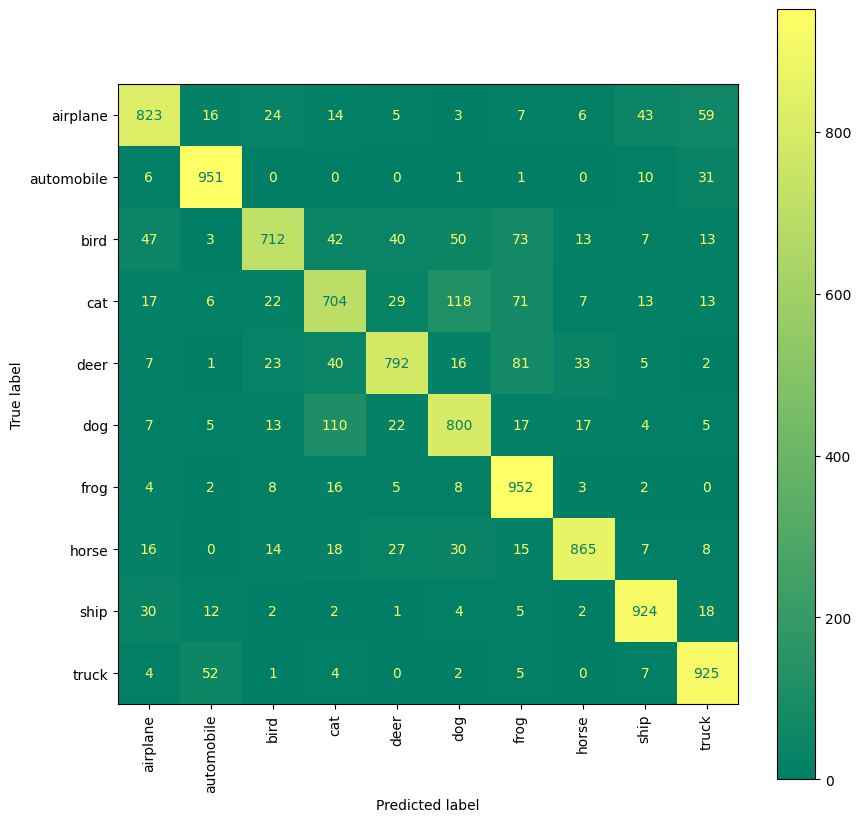

In [14]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1000
           1       0.91      0.95      0.93      1000
           2       0.87      0.71      0.78      1000
           3       0.74      0.70      0.72      1000
           4       0.86      0.79      0.82      1000
           5       0.78      0.80      0.79      1000
           6       0.78      0.95      0.85      1000
           7       0.91      0.86      0.89      1000
           8       0.90      0.92      0.91      1000
           9       0.86      0.93      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



## Test on one image

 Image 100 is [4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The model predict that image 100 is 7


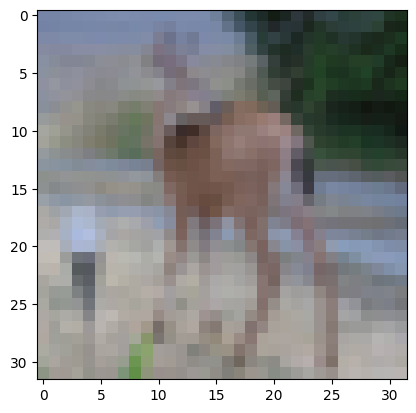

In [16]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

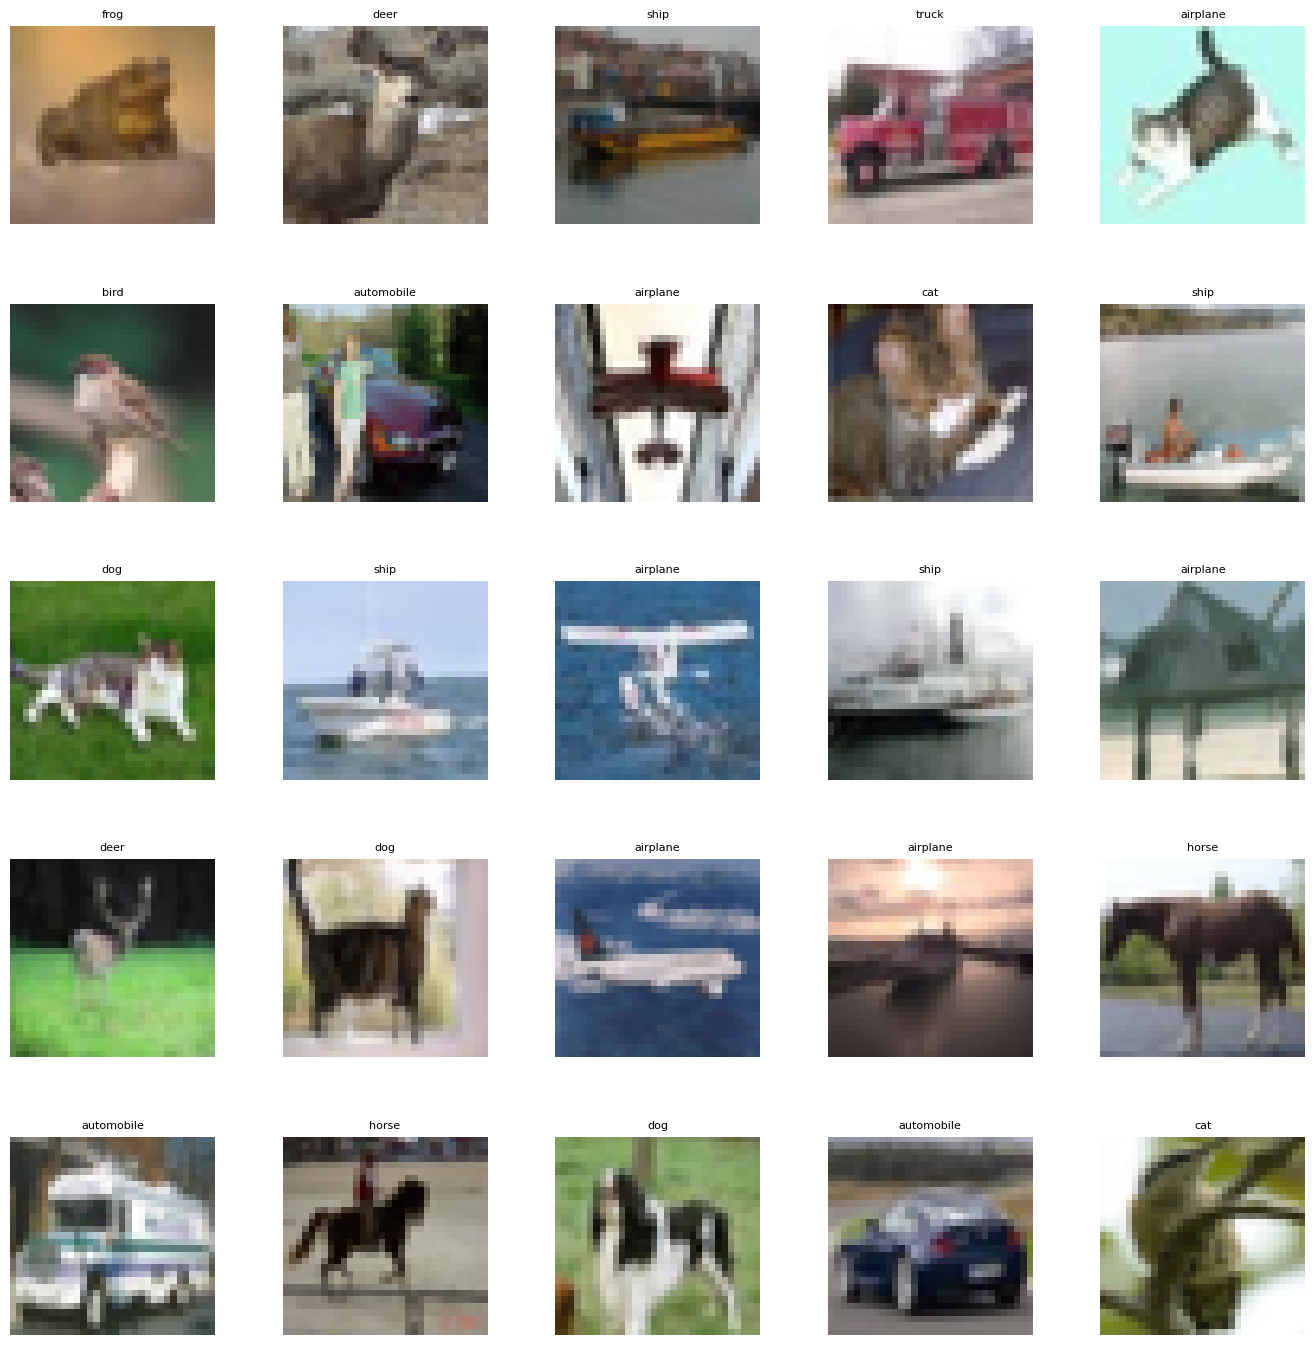

In [17]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [18]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


/var/folders/v0/_dw0wx1s0kj764555vtjs38h0000gn/T/ipykernel_90312/2929771486.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
/var/folders/v0/_dw0wx1s0kj764555vtjs38h0000gn/T/ipykernel_90312/2929771486.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions_array, true_label = predictions_array, int(true_label[i])


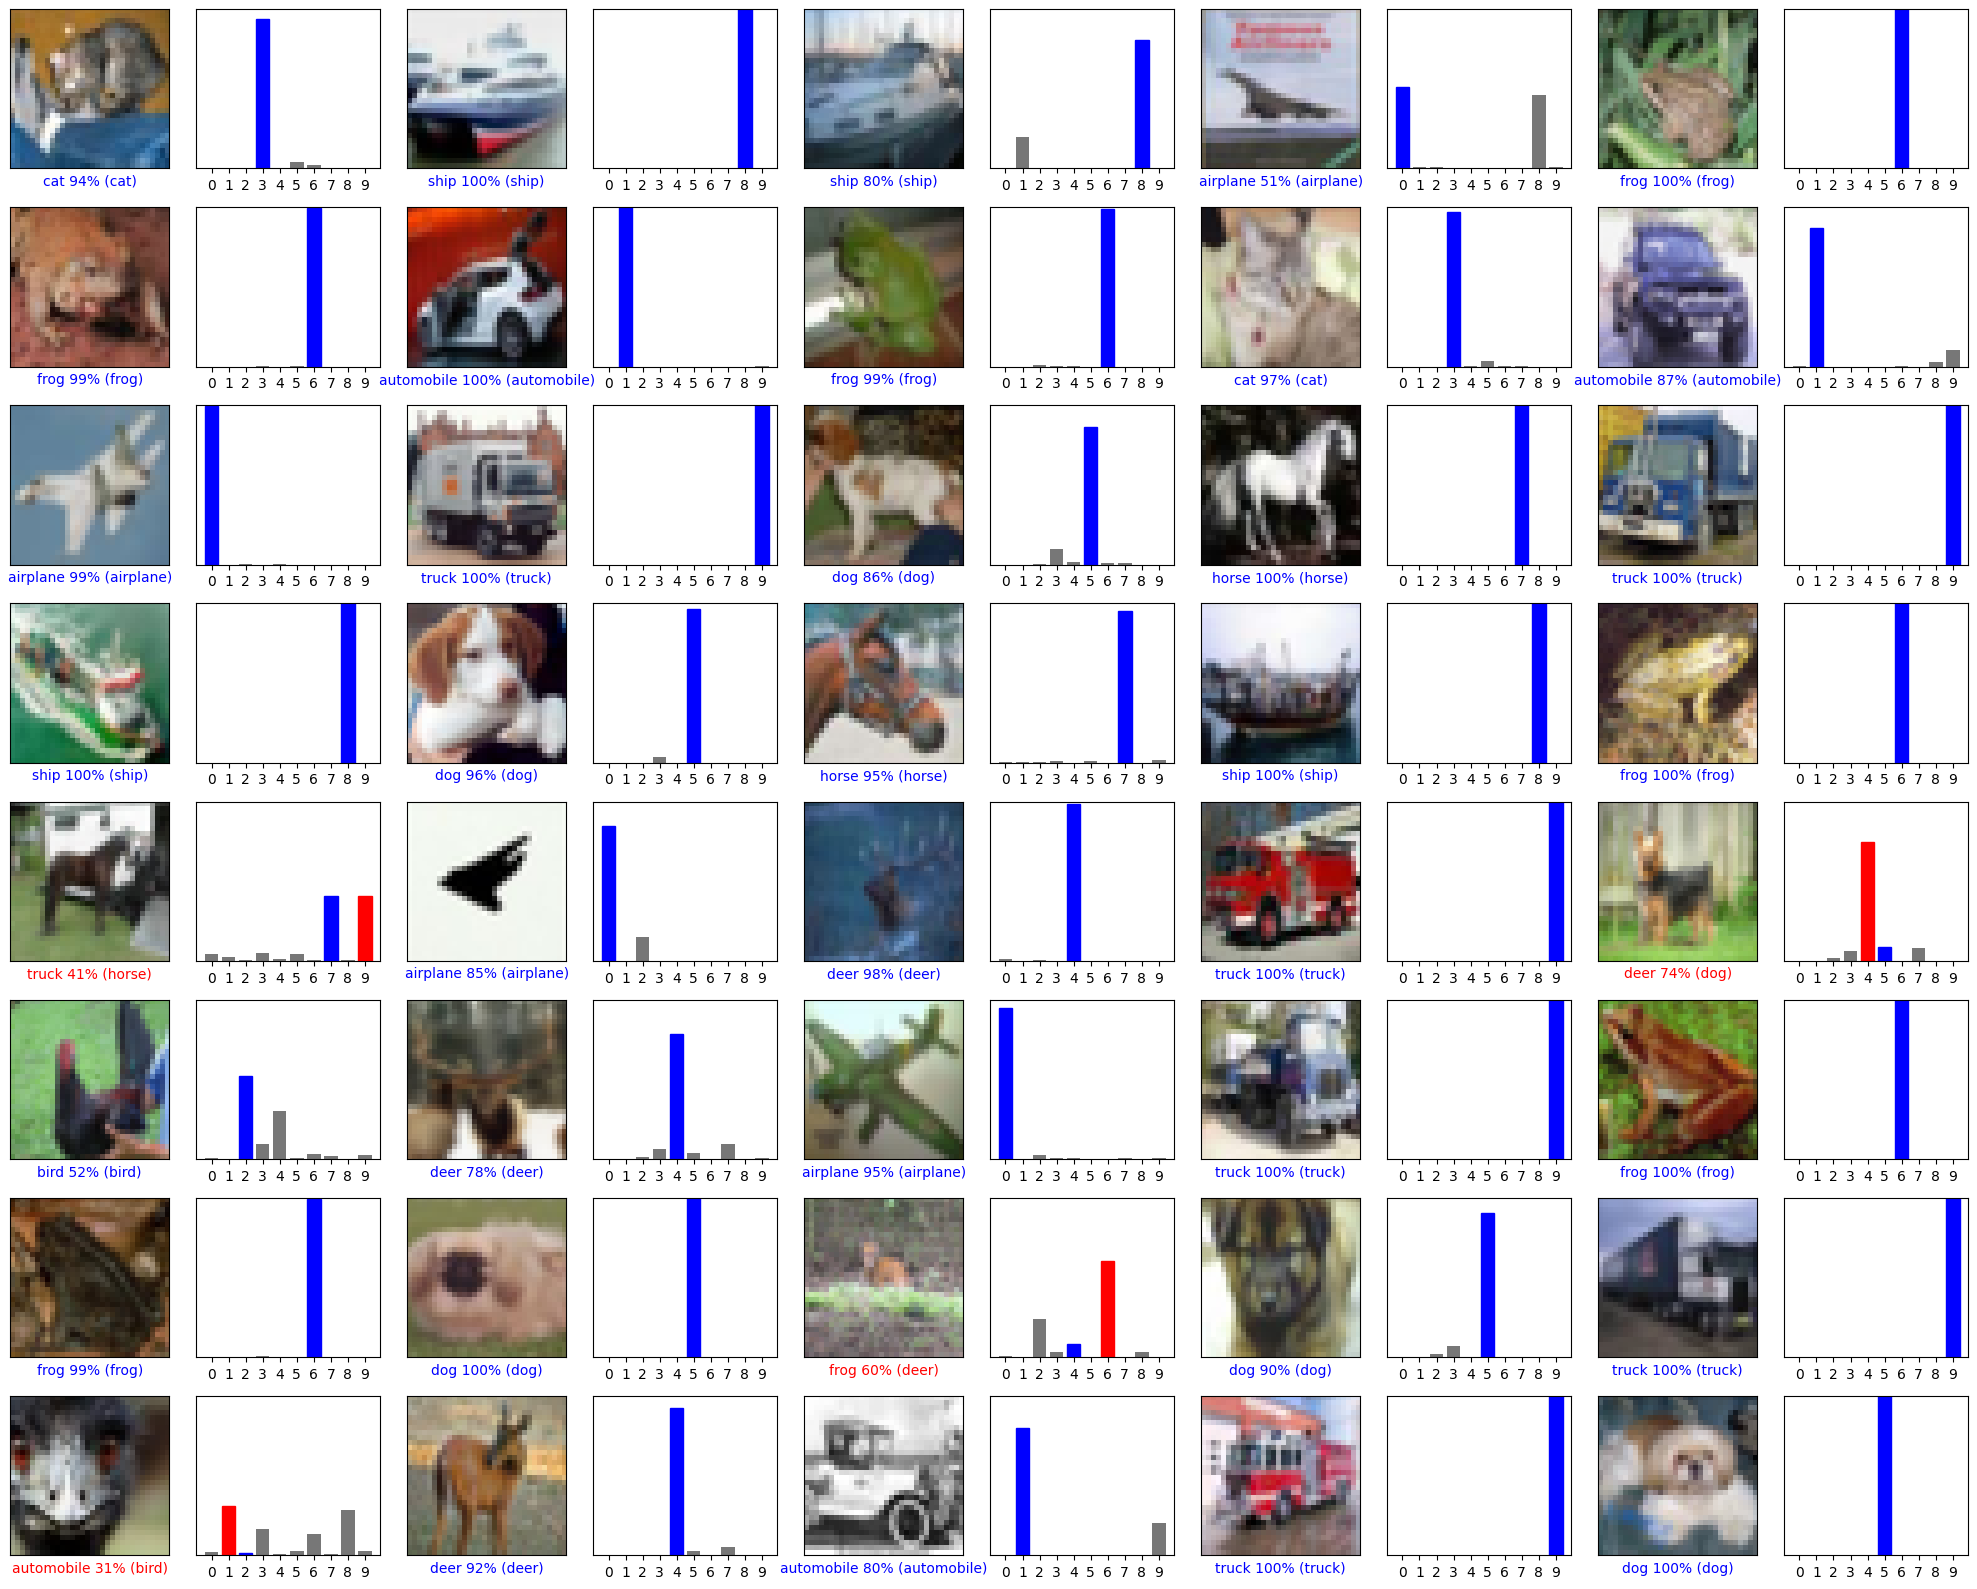

In [19]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()